Data Focused Python  
Final Project  
name  
May 7, 2018  

## Part 1 Extracting data
We extracted product data such as product name, price, and customer ratings from eBay, Walmart, and Flipkart. Methods to extract data are web scraping and web API.  
(Note: Amazon does not seem to permit to scrape nor to offer star ratings by API. For this reason, we did not choose Amazon in this project.)

### (1) Extracting data from eBay by web scraping
We first identified the number of results which was displayed at the top of a search result page. Then, we calculated number of pages so that we could access every result page. (Since 50 items are displayed per page, we can solve for the number of pages by dividing the number of items hit by 50.)  
In each page, we extracted 'list' tags containing star-ratings, title, and price information of a product, and stored them in to a list ('products_table').  
Finally, we converted the list into Pandas data frame of product name, price, and customer ratings obtained ('products_table_df').

In [1]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time
import math
import pandas as pd

In [2]:
# Cited from lab 3
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

In [3]:
search_word = "Samsung phones"
payload = {'_nkw':search_word}
    
r = requests.get('https://www.ebay.com/sch/i.html', params = payload)
page = r.content
soup = bs(page, "html.parser")

# Count the number of pages of the search result
num_items = soup.find_all("span", class_ = "rcnt")
num_items = get_text_from_elements(num_items)
num_items = int(num_items[-1].replace(",","")) # replace "1,234" into "1234" and convert into integer

items_per_page = 50
link_pages = int(math.ceil(num_items / items_per_page))

print("The number of items hit by the search is", num_items)
print("The number of pages is", link_pages)

The number of items hit by the search is 59375
The number of pages is 1188


In [4]:
# Scrape the data from each search result page using for loop (this may take much time)

# Create empty lists
products_table = []

# For each search result page, get all the review rating, title, and price data
for i, page in enumerate(range(min(link_pages, 100))): # to avoid kernel dead, limit maximum pages (100 items * 50 pages)
    page_num = i + 1
    payload = {'_nkw':search_word, '_pgn': page_num}
    r = requests.get('https://www.ebay.com/sch/i.html', params = payload)
    page = r.content
    soup = bs(page, "html.parser")

    # Get product data and store in a list of "products"
    result_items = soup.find_all('div', id = "ResultSetItems")
    r_lists = range(2, items_per_page + 1)
    products = result_items[0].find_all("li", r = "1")
    for r_list in r_lists:
        product = result_items[0].find_all("li", r = str(r_list))[0] # To make class bs4.element.ResultSet into bs4.element.Tag
        products.append(product)

    
    for product in products:
        # Remove products which have not review ratings
        if len(product.find_all("div", class_ = "star-ratings")) != 0:
            # Get review rating data
            review = float(product.find('div', class_ = "star-ratings").find("a")["aria-label"].split(" ")[1])
            # Get title data
            title = product.find('h3', class_ = "lvtitle").find("a").text
            # Get Price data
            price = float(product.find('li', class_ = "lvprice prc").find("span").text.split("$")[-1].replace(",",""))
            # Merge the data
            product_table = [title, review, price]
            # Mutate the data table
            products_table.append(product_table)

            
#print(products_table) # you can print the list by this line
print("The number of obtained products is", len(products_table))

The number of obtained products is 1761


In [5]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in products_table:
    if product[0] not in product_name:
        product_name[product[0]] = 1
    else:
        product_name[product[0]] += 1   
print("The number of unique products is", len(product_name), "out of", len(products_table))

The number of unique products is 1433 out of 1761


In [6]:
# Convert into Pandas Data frame
import pandas as pd
products_table_df = pd.DataFrame(products_table, columns = ["Name", "Ratings", "Price"])
# Print the raw data
products_table_df

,Name,Ratings,Price
0,"Samsung Galaxy S8 64GB 5.8"" Display AT&T Unloc...",4.95,519.99
1,Samsung Galaxy S5 S4 - Factory Unlocked - GSM ...,4.71,168.99
2,New Samsung Galaxy S6 SM-G920T 32GB T-Mobile B...,4.61,225.00
3,\r\n\t\t\t\tSamsung Galaxy S9+ Plus SM-G965F/D...,4.80,749.00
4,Samsung Galaxy S8 G950U / S8 Plus G955U / Note...,4.29,699.95
5,Factory Unlocked Samsung Galaxy S7 Edge GSM LT...,4.62,365.99
6,NEW Samsung Galaxy S5 SM-G900A AT&T Factory Un...,4.38,138.88
7,Samsung G930 Galaxy S7 32GB Android Verizon Wi...,4.67,184.95
8,Samsung Galaxy S7 SM-G930T - 32GB (T-Mobile UN...,4.56,298.99
9,\r\n\t\t\t\tNew Unlocked White Samsung Galaxy ...,4.48,299.88


In [7]:
# Output to CSV file as raw data
products_table_df.to_csv("ebay_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted some special characters including '\r', '\n', and '\t'
- Sorted by product name

In [8]:
# Data Cleaning
# Remove duplicated products
products_table_df2 = products_table_df.drop_duplicates("Name")

# Delele "'\r', '\n', '\t'" from Name column
products_table_df2.loc[:, "Name"] = [name.replace("\t", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("\r", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("\n", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("!!", "") for name in products_table_df2["Name"]]

# Sort by product name and reset index
products_table_df2 = products_table_df2.sort_values(by="Name")
products_table_df2 = products_table_df2.reset_index(drop=True)

C:\Users\prans\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
# Print the processed data
products_table_df2

,Name,Ratings,Price
0,"""NEW"" Samsung Galaxy Note 4 SM-N910A AT&T UNLO...",4.47,169.88
1,"""NEW"" Samsung Galaxy S6 Edge+ Plus SM-G928A 32...",4.32,299.88
2,"""NEW"" Samsung Galaxy S7 Edge SM-G935A AT&T Unl...",4.68,319.88
3,"""NEW""Samsung Galaxy S7 edge S6 S5 S4 Note 2 3 ...",4.49,399.99
4,"""New"" Samsung Galaxy Note 5 N920P 32GB Gold (S...",4.44,229.99
5,"""New"" Samsung Galaxy Note 5 Verizon Wireless U...",4.37,254.99
6,"""New"" Samsung Galaxy S6 Active SM-G890A 32GB G...",4.35,169.95
7,(NEW & SEALED) Samsung Galaxy S4 i9505 | 16GB ...,4.60,138.47
8,"(UNLOCKED) Samsung Galaxy S6 SM-G920, 32 GB, G...",4.32,144.90
9,*UNLOCKED* (AT&T) SAMSUNG SGH-A847 RUGBY II 2 ...,4.50,25.99


In [10]:
# Output to CSV file as processed data
products_table_df2.to_csv("ebay_clean.csv")

### (2) Extracting data from Walmart by web API
To diversify methods of acquiring data, we decided to extract Walmart's data using web API. First, we registered Walmart Open API (Product Lookup API), then read the API documents through to understand query parameters and the structure of response. Next, we set query parameters regarding number of items obtained per request (as 25 items) and staring point of each request, then got JSON files for each request. Using for loop, we iterated collecting JSON data 40 times so that we could acquire 1,000 items in total. This is because Walmart Open API offers up to only 1,000 items per keyword. After that, I converted the JSON data into Pandas data frame consisting of product name, price, and customer ratings ('product_table').  
We found that extracting data by web API is relatively easier than by web scraping, although it took several hour to understand how to sign up Walmart Open API and how to use it to obtain product data.

In [11]:
import requests
import pandas as pd

In [12]:
# Determine a search word
search_word = "Samsung phones"

# Create a new list to store product information
product_table = pd.DataFrame()

In [13]:
# Extract data of 1000(=25*40) items (1st-1000th item)
# According to the Walmart API documentation, "Pagination is limited to the top 1000 items for a particular search." 
for i in range(40):
    payload = {'apiKey':'t5f6xrjyupatsqspx28aprtj', 'query':search_word, 'numItems':'25', 'start':str(25*i+1)}
    r = requests.get('http://api.walmartlabs.com/v1/search', params = payload)
    data = r.json()
    items = pd.DataFrame(data["items"], columns=['name', 'salePrice','customerRating'])
    product_table = product_table.append(items, ignore_index = True)
print(len(product_table),"products obtained from total results of", data["totalResults"], "by this code ")

1000 products obtained from total results of 417497 by this code 


In [14]:
# Print the raw data
product_table

,name,salePrice,customerRating
0,Straight Talk Samsung Galaxy J3 Luna Pro 16GB ...,59.99,3.914
1,Straight Talk Samsung Galaxy J7 Sky Pro 16GB P...,99.99,4.441
2,AT PREPAID Samsung Galaxy Express Prime 2 16GB...,99.00,4.077
3,Total Wireless Samsung J7 Sky Pro 16GB Prepaid...,149.99,4.5
4,Straight Talk Samsung Galaxy J1 Luna 8GB Prepa...,29.99,2.49
5,Walmart Family Mobile Samsung Luna Pro Prepaid...,79.99,3.286
6,Total Wireless Samsung Galaxy J3 Luna Pro 16GB...,59.00,3.667
7,Boost Mobile Samsung J3 Emerge 16GB Prepaid Sm...,79.00,4.276
8,Cricket Wireless Samsung Galaxy Sol 2 16GB Pre...,99.99,NaN
9,TracFone Samsung Galaxy J3 Sky 4GB Prepaid Sma...,99.99,4.277


In [15]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in product_table['name']:
    if product not in product_name:
        product_name[product] = 1
    else:
        product_name[product] += 1   
print("# of unique products is", len(product_name), "out of", len(product_table['name']))

# of unique products is 736 out of 1000


In [16]:
# Output to CSV file as raw data
product_table.to_csv("walmart_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted rows with null data
- Sorted by product name

In [17]:
# Data Cleaning
# Change the column names
product_table.columns = ["Name", "Price", "Ratings"]

# Change the order of the columns
product_table2 = product_table.loc[:,["Name", "Ratings", "Price"]]

# Remove duplicated products
product_table2 = product_table2.drop_duplicates("Name")

# Drop rows containing null data
product_table2 = product_table2.dropna()

# Sort by product name and reset index
product_table2 = product_table2.sort_values(by="Name")
product_table2 = product_table2.reset_index(drop=True)

In [18]:
# Print the processed data
product_table2

,Name,Ratings,Price
0,"""Acuvar 6.5"""" inch Flexible Tripod With Univer...",4.704,5.99
1,"""New Galaxy S6 Edge Plus 32GB G928A by Samsung...",5.0,369.95
2,"""New J7 Pro 2017 32GB J730GM/DS by Samsung GSM...",4.0,267.95
3,"""SAMSUNG Convoy 4 - 2.4"""" TFT 512MB - Verizon ...",3.2,92.50
4,"""Samsung Galaxy Tab A 7.0"""" LTE Tablet (Factor...",4.5,185.95
5,"""Value Pack + for 5.5"""" Samsung Galaxy J7 2017...",4.0,11.99
6,"""Value Pack + for 6.2"""" Samsung S9 + PLUS Gala...",3.0,11.49
7,"""Value Pack + for 6.2"""" Samsung S9 + PLUS Gala...",3.0,13.49
8,"""Value Pack for 5.5"""" Samsung Galaxy J7 2017 S...",5.0,10.99
9,"""for 5.5"""" Samsung Galaxy J7 2017 sky pro J730...",3.0,8.99


In [19]:
# Output to CSV file as processed data
product_table2.to_csv("walmart_clean.csv")

### (3) Extracting data from Flipkart by web scraping
We first identified the number of result pages which was displayed at the bottom of a search result page. Then, we set queries of page number as well as the search word, and did loop processing to access to all the page of seach results. In each page, we extracted 'div' tags containing star-ratings, title, and price information of a product, and stored them in to a list ('products_table'). One thing that we got confused was that the attribute of the 'div' tags was different among product categories. Thus, it took us some time to examine HTML source whenever we tried to change search keywords. Finally, we converted the list into Pandas data frame of product name, price, and customer ratings obtained ('products_table_df').

In [20]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time

In [21]:
# Cited from lab 3
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

In [22]:
search_word = "Samsung phones"
#payload = {'q':search_word}
payload = {"page": 1, 'q':search_word, 'viewType':'list'}

r = requests.get('http://www.flipkart.com/search', params = payload)
page = r.content
soup = bs(page, "html.parser")

In [23]:
# Count the number of pages of the search result
link_pages = soup.find_all("span", class_ = "_3v8VuN")
link_pages = get_text_from_elements(link_pages)
# To split the string like 'Page 3 of 26' by space, extract a row from the list of one row ('link_pages')
if link_pages == []:
    link_pages = 1
else:
    link_pages = link_pages[0].split(" ")
    link_pages = int(link_pages[-1].replace(",","")) # replace "1,234" into "1234" and convert into integer
print("The number of pages is", link_pages)

The number of pages is 1


In [24]:
# Scrape the data from each search result page using for loop

# Create empty lists
products_table = []

# For each search result page, get all the review rating, title, and price data
for i, page in enumerate(range(min(link_pages, 50))): # to avoid kernel dead, limit maximum pages (40 items * 50 pages)
    page_num = i + 1
    payload = {"page": page_num, 'q':search_word, 'viewType':'list'}
    r = requests.get('http://www.flipkart.com/search', params = payload)
    page = r.content
    soup = bs(page, "html.parser")

    # Get product data (eliminating recently reviewed items and recommended items)
#    products = soup.find_all('div', class_ = "MP_3W3 _31eJXZ") if you search toys, use this line
    products = soup.find_all('div', class_ = "_1-2Iqu row") # if you search electronics such as laptops, use this line
    for product in products:
        # Remove products which have not review ratings
        if len(product.find_all("div", class_ = "hGSR34 _2beYZw")) != 0:
            # Get review rating data
            review_element = product.find_all("div", class_ = "hGSR34 _2beYZw")
            review_text = review_element[0].text
            review = review_text.split(" ")[0]
            review = float(review)
            # Get title data
#            title = product.find_all("a", class_ = "_2cLu-l")[0].text # if you search toys, use this line
            title = product.find_all("div", class_ = "_3wU53n")[0].text # if you search electronics such as laptops, use this line
            # Get Price data
            price = product.find_all("div", class_ = "_1vC4OE")[0].text
            # Merge the data
            product_table = [title, review, price]
            # Mutate the data table
            products_table.append(product_table)
    
#print(products_table) # You can print the list by this line
print("The number of products is", len(products_table))

The number of products is 24


In [25]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in products_table:
    if product[0] not in product_name:
        product_name[product[0]] = 1
    else:
        product_name[product[0]] += 1   
print("The number of unique products is", len(product_name), "out of", len(products_table))

The number of unique products is 21 out of 24


In [26]:
# Convert into Pandas Data frame
import pandas as pd
products_table_df = pd.DataFrame(products_table, columns = ["Name", "Ratings", "Price"])
# Print the raw table
products_table_df

,Name,Ratings,Price
0,"Samsung Galaxy On Max (Gold, 32 GB)",4.3,"₹13,900"
1,"Samsung Galaxy On Nxt (Gold, 64 GB)",4.2,"₹12,900"
2,"Samsung Galaxy On Max (Black, 32 GB)",4.3,"₹13,900"
3,"Samsung Galaxy J3 Pro (Gold, 16 GB)",4.2,"₹7,490"
4,"Samsung Galaxy On Nxt (Black, 64 GB)",4.2,"₹12,900"
5,Samsung Guru Music 2,4.2,"₹1,625"
6,Samsung Guru Music 2,4.2,"₹1,625"
7,"Samsung Galaxy J3 Pro (Black, 16 GB)",4.2,"₹7,490"
8,"Samsung J7 Max (Gold, 32 GB)",4.3,"₹14,900"
9,"Samsung J7 Max (Black, 32 GB)",4.3,"₹14,900"


In [27]:
# Output to CSV file as raw data
products_table_df.to_csv("flipkart_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted Indian Rupee mark from Price
- Sorted by product name

In [28]:
# Data Cleaning
# Remove duplicated products
products_table_df2 = products_table_df.drop_duplicates("Name")

# Eliminate "₹" (Indian Rupee mark from Price) 
products_table_df2.loc[:, "Price"] = [int(price[1:].replace(",", "")) for price in products_table_df2["Price"]]

# Sort by product name and reset index
products_table_df2 = products_table_df2.sort_values(by="Name")
products_table_df2 = products_table_df2.reset_index(drop=True)

C:\Users\prans\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
# Print the processed table
products_table_df2

,Name,Ratings,Price
0,"Samsung Galaxy C7 Pro (Navy Blue, 64 GB)",4.4,22400
1,"Samsung Galaxy J2 Pro (Gold, 16 GB)",4.1,7690
2,"Samsung Galaxy J3 Pro (Black, 16 GB)",4.2,7490
3,"Samsung Galaxy J3 Pro (Gold, 16 GB)",4.2,7490
4,"Samsung Galaxy J7 Nxt (Black, 16 GB)",4.3,9490
5,"Samsung Galaxy J7 Nxt (Gold, 16 GB)",4.3,9490
6,"Samsung Galaxy J7 Pro (Black, 64 GB)",4.4,18900
7,"Samsung Galaxy On Max (Black, 32 GB)",4.3,13900
8,"Samsung Galaxy On Max (Gold, 32 GB)",4.3,13900
9,"Samsung Galaxy On Nxt (Black, 16 GB)",4.2,10999


In [30]:
# Output to CSV file as processed data
products_table_df2.to_csv("flipkart_clean.csv")

## Part 2 Merging the data
We developed algorithm to merge the data from three sources. This algorithm was implemented in another tool Alteryx.

In [31]:
import pandas as pd

# Read the three processed data from each csv file and store in each data frame
ebay_data = pd.read_csv("ebay_clean.csv", index_col = 0)
walmart_data = pd.read_csv("walmart_clean.csv", index_col = 0)
flipkart_data = pd.read_csv("flipkart_clean.csv", index_col = 0)

### (1) Outer Join of eBay data and Walmart data

### (2) Left Join of the merged data and Flipkart data

## Part 3 Visualizing the data

### (1) Pre-merged data
First, we explored pre-merged data to search for any interesting findigs. The outputs of the exploration are as follows.

In [48]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
import matplotlib
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

# Read the three processed data from each csv file and store in each data frame
ebay_data = pd.read_csv("ebay_clean.csv", index_col = 0)
walmart_data = pd.read_csv("walmart_clean.csv", index_col = 0)
flipkart_data = pd.read_csv("flipkart_clean.csv", index_col = 0)
#merged_data = pd.read_csv("merged.csv", index_col = 0)
matched_record_mackbook = pd.read_csv('Matched Records Mackbook Final.csv', index_col=0)
matched_record_samsung = pd.read_csv('Matched Records Samsung Final.csv',encoding='latin-1', index_col=0)
matched_record_sony = pd.read_csv('Matched Records SONY Final.csv', index_col=0)

The descriptive statistics of product ("Samsung phones") data on eBay is as follows. We can see that the mean ratings is 4.56, which is relatively high. Thus, eBay users might tend to rate items high.

In [38]:
ebay_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,1433.000000,1433.000000
mean,4.551417,208.268137
std,0.303436,148.868771
min,1.000000,0.010000
25%,4.470000,115.000000
50%,4.560000,180.000000
75%,4.670000,249.980000
max,5.000000,1016.390000


Below is the descriptive statistics of product ("Samsung phones") data on Walmart. Contrary to eBay, Walmart users migit tend to rate items low because the mean ratings is 3.81. However, its standard devieation is much higher than eBay. This implies that Walmart sells both products with very high ratings and products with very low ratings.  
Also, the mean price (in US dollar) of Walmart is lower than that of eBay. This implies that Walmart sells cheaper products than eBay, or many relatively irrelevant cheaper items (such as Samsung phone cases or holders) were just hit by search.

In [39]:
walmart_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,238.000000,238.000000
mean,3.839592,85.301513
std,1.107006,156.173851
min,1.000000,1.790000
25%,3.117750,9.390000
50%,4.000000,14.990000
75%,4.964250,91.637500
max,5.000000,899.000000


The descriptive statistics of product ("Samsung phones") data on Flipkart is as follows. We can see that the mean ratings is 4.08 and the standard deviation is as large as that of eBay. Since 1 (one) US dollar equals to approximately 67 Indian rupees, the mean price is almost the same value as 250 US dollars, which is relatively high. 

In [40]:
flipkart_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,21.000000,21.000000
mean,4.266667,13427.523810
std,0.123828,13013.181093
min,4.100000,1100.000000
25%,4.200000,7490.000000
50%,4.200000,10999.000000
75%,4.300000,14900.000000
max,4.700000,64900.000000


The following plot show the relationship between price and customer ratings of items on eBay. This plot shows that most items are rated high and that there are no expensive items that have lower ratings.  
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on eBay')

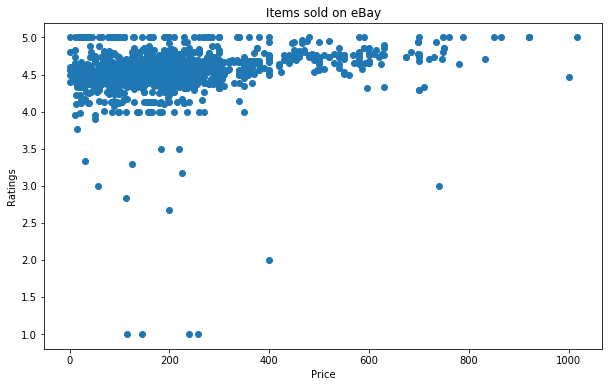

In [41]:
plt.plot(ebay_data["Price"], ebay_data["Ratings"], "o")
#plt.semilogx(ebay_data["Price"], ebay_data["Ratings"], "o")
#plt.loglog(ebay_data["Price"], ebay_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on eBay")

The following plot show the relationship between price and customer ratings of items on Walmart. This plot indicates that there might be a weak linear positive relationship between price and ratings. Also, we can say that there are no expensive items that have lower ratings, too.   
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on Walmart')

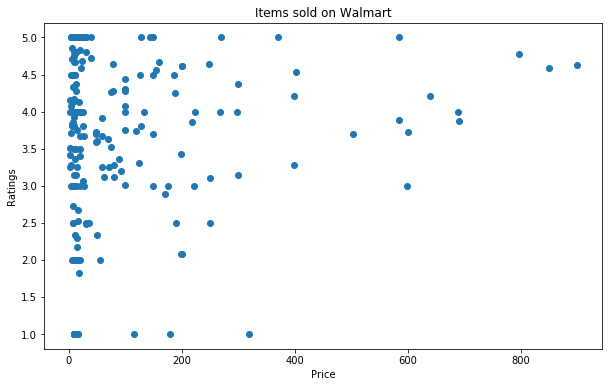

In [42]:
plt.plot(walmart_data["Price"], walmart_data["Ratings"], "o")
#plt.semilogx(walmart_data["Price"], walmart_data["Ratings"], "o")
#plt.loglog(walmart_data["Price"], walmart_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on Walmart")

The following plot show the relationship between price and customer ratings of items on Flipkart. This plot demonstrates that there might be a weak linear positive relationship between price and ratings, but customer ratings appear to be discrete. Also, we can say that there are no expensive items that have lower ratings, too.   
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on Flipkart')

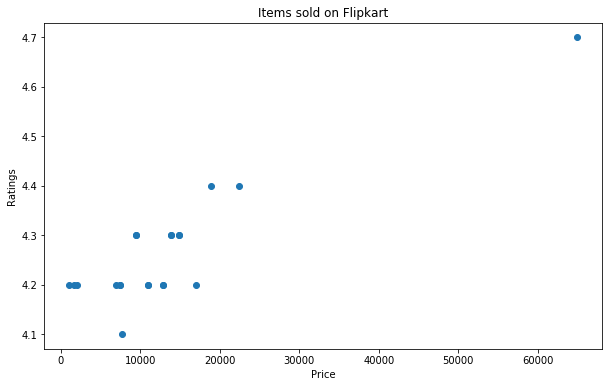

In [43]:
plt.plot(flipkart_data["Price"], flipkart_data["Ratings"], "o")
#plt.semilogx(flipkart_data["Price"], flipkart_data["Ratings"], "o")
#plt.loglog(flipkart_data["Price"], flipkart_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on Flipkart")

### (2) Matched data
Next, we explored the matched data.

In [49]:
matched_record_mackbook['Left_Right_Price'] = matched_record_mackbook['Left_Right_Price'].map(lambda x: x/66.62)

In [64]:
mac_ebay_mean = matched_record_mackbook['Price'].mean()
mac_flipkart_mean = matched_record_mackbook['Left_Right_Price'].mean()
mac_walmart_mean = matched_record_mackbook['Right_Price'].mean()


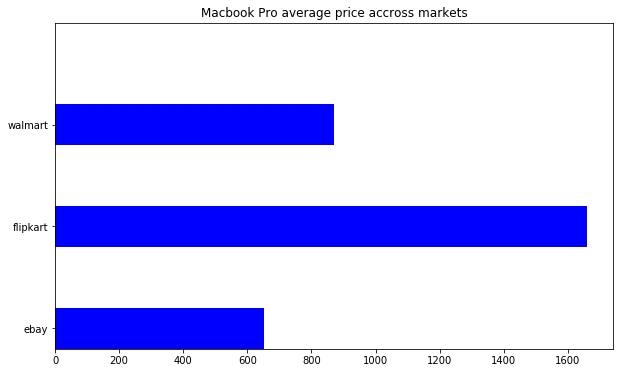

In [88]:
df = pd.DataFrame(dict(graph=['ebay', 'flipkart', 'walmart'],price=[mac_ebay_mean, mac_flipkart_mean, mac_walmart_mean])) 
i = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(i, df.price, width, color='blue')
ax.set(yticks=i, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
plt.title("Macbook Pro average price accross markets")
plt.show()

In [86]:
matched_record_samsung['Left_Right_Price'] = matched_record_samsung['Left_Right_Price'].map(lambda x: x/66.62)

In [87]:
samsung_ebay_mean = matched_record_samsung['Price'].mean()
samsung_flipkart_mean = matched_record_samsung['Left_Right_Price'].mean()
samsung_walmart_mean = matched_record_samsung['Right_Price'].mean()


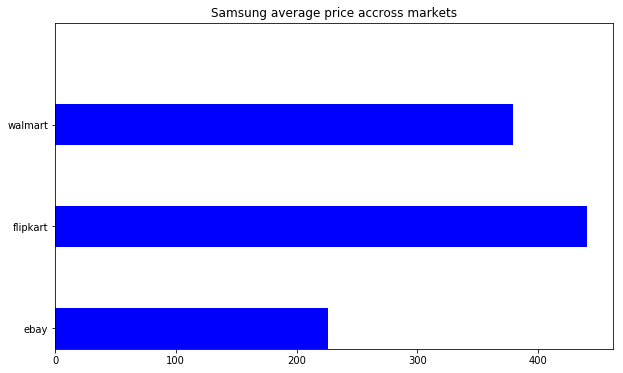

In [90]:
df = pd.DataFrame(dict(graph=['ebay', 'flipkart', 'walmart'],price=[samsung_ebay_mean, samsung_flipkart_mean, samsung_walmart_mean])) 
i = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(i, df.price, width, color='blue')
ax.set(yticks=i, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
plt.title("Samsung average price accross markets")
plt.show()

In [91]:
matched_record_sony['Left_Right_Price'] = matched_record_sony['Left_Right_Price'].map(lambda x: x/66.62)

In [92]:
sony_ebay_mean = matched_record_sony['Price'].mean()
sony_flipkart_mean = matched_record_sony['Left_Right_Price'].mean()
sony_walmart_mean = matched_record_sony['Right_Price'].mean()


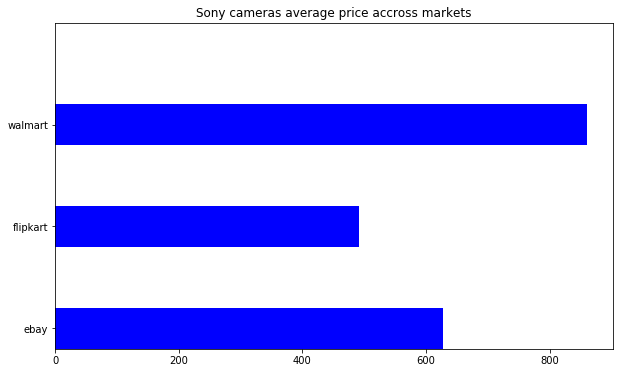

In [94]:
df = pd.DataFrame(dict(graph=['ebay', 'flipkart', 'walmart'],price=[sony_ebay_mean, sony_flipkart_mean, sony_walmart_mean])) 
i = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(i, df.price, width, color='blue')
ax.set(yticks=i, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
plt.title("Sony cameras average price accross markets")
plt.show()

### Conlusion
- For Macbook Flipkart have highest average price and ebay has the lowest
- For Samsung phones Flipkart has highest average price and ebay has the lowest
- For Sony Cameras Walmart has high average price and Flipkart has the lowest

### References
- Achin Sagar, "Extracting Flipkart reviews through web scraping", Quora, accessed April 8, 2018, https://codeexperiments.quora.com/Extracting-Flipkart-reviews-through-web-scraping
- Search API, "Walmart Open API", https://developer.walmartlabs.com/docs/read/Search_API